# House Prices: Advanced Regression Techniques
Joanna Broniarek

Before starting project I read some articles:
1. https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

    + Select Data: Integrate data, de-normalize it into a dataset, collect it together.
    + Preprocess Data: Format it, clean it, sample it so you can work with it.
    + Transform Data: Feature Engineer happens here.
    + Model Data: Create models, evaluate them and tune them.
    + 
2. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

2. 6 top factors  that influence a home’s value: https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/
3. https://www.rochesterrealestateblog.com/what-factors-influence-the-sale-price-of-a-home/
_______________

I also took some inspiration and used some techniques of other people, but I did not hard-copied. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
import scipy

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)

Environment specification:

python 3.11.4
numpy 1.24.2
scipy 1.11.3
seaborn 0.13.1
sklearn 1.3.2
pandas 2.0.0


### Reading CSV file as Dataframe:

In [7]:
# kaggle train data
data_df = pd.read_csv("train.csv")
# kaggle test data
test_df = pd.read_csv("test.csv")

In [8]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### Exploratory Data Analysis and Data tidying

I noticed that the dataset consists of 38 numerical columns of 81 all. 
Morover, some columns contain missing data, i.e."LotFrontage", "MasVnrArea".

**The prediction target is 'SalePrice'. Let's look closer to this column.**

In [9]:
# Basic summary:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='SalePrice'>

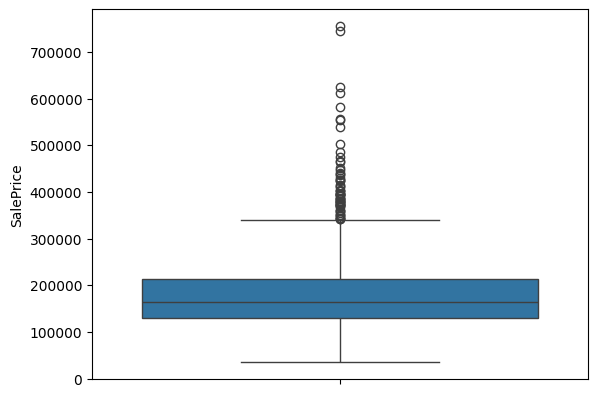

In [10]:
sns.boxplot(data_df['SalePrice'])

There are two outliers with prices more than 700000.

<Axes: xlabel='SalePrice', ylabel='Density'>

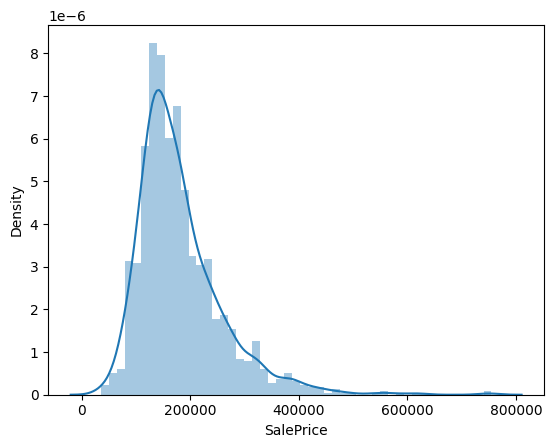

In [11]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

I noticed that it is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k.

In [12]:
# Positive Skeweness:
data_df['SalePrice'].skew()

1.8828757597682129

In order to be SalePrice more normal I do Logarithm transformation.

In [13]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

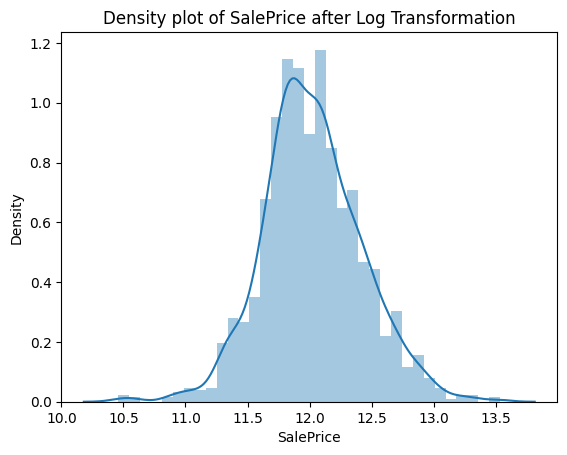

In [14]:
# SalePrice after Log-transformation
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")

In [15]:
y_train = data_df["SalePrice"]

#### Columns with Nan values

At first, I am checking the fraction of Nan values in each column. 

In [16]:
col_nan = data_df.isna().sum() / data_df.shape[0]

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

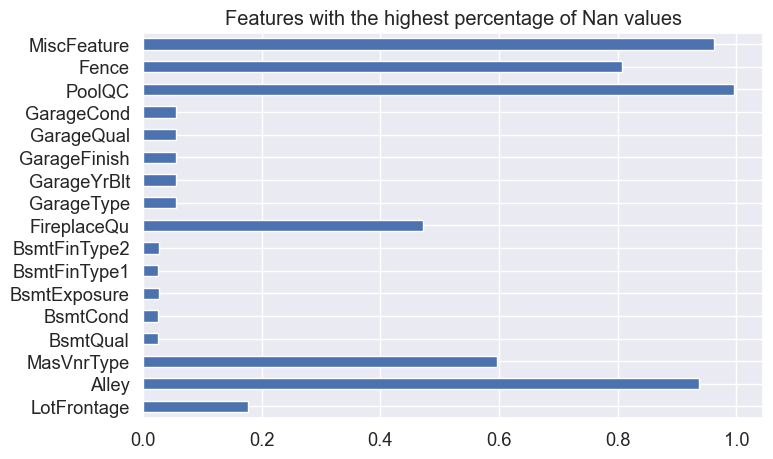

In [17]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

In [18]:
""" In some of my trials I removed columns with more than 90% od NaN values, 
    but finally I missed this step and left them for further analysis."""

# drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.95) if i==True]]
# data_df = data_df.drop(drop_out_columns, axis=1)
# test_df = test_df.drop(drop_out_columns, axis=1)

' In some of my trials I removed columns with more than 90% od NaN values, \n    but finally I missed this step and left them for further analysis.'

**Removing Id column**

In [19]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

**Removing columns that contain the same value in 100%**

According to basic statistics provided on Kaggle competiton website, the columns Street and Utilities contain only one value "Pave" and "AllPub" respectively.

In [20]:
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

 **Removing outliers**

Removing outliers is important step in data analysis. However, while removing outliers in ML we should be careful, because we do not know if there are not any outliers in test set.

I used two techniques: more and less rigorous for this data.

The first one was **Z-score method**. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.  
I set **threshold = 3** to identify outliers.
$$ z = \frac{x - \mu}{\sigma} $$


In [21]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]  
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

In [22]:
# clear_data is a dataframe with train data after removing outliers

# clear_data, removed_data = remove_outliers(data_df, threshold = 3, removed=True, 
#                              columns=['GrLivArea'])

Finally, after few trials I used less rigorous method. I just made a plot for SalePrice and GrLivArea and removed those which seems to be outliers.

** Removing outliers according to GrLivArea**

In [24]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(data_df["GrLivArea"], data_df["SalePrice"])
# plt.vlines(4500, ymax=800000, ymin=0)
plt.title("GrLivArea vs SalePrice")

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 800x500 with 0 Axes>

In [25]:
# I decided to remove those records where 'GrLivArea' is more than 4500. We can see on plot that they have a vey low price.
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)

In [26]:
# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

**GarageYrBlt feature**

I checked if there are records that YearBuilt or GarageYrBlt have further year than 2017.

In [27]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [28]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [29]:
all_data.loc[2590, 'GarageYrBlt'] = 2007

**LotFrontage feature**

LotFrontage is  a linear feet of street connected to property. I think it is a high probability that these values are similar to houses in the same Neighborhood. I check some statistics for them.

In [30]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [31]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**Transformation of some numerical variables that are actually categorical.**

In [32]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [33]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

**Replacing missing values in the rest of numerical columns**

For the other numerical data I will also estimate them according to their statistics and for that I will use SimpleImputer object from sklearn library. For columns: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath and BsmtHalfBath , MasVnrArea I will fill Nan values with constant = 0 and for the rest with median.

In [34]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [35]:
# Generating numerical features as input to DataFrameMapper.  
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


**Categorical to numeral**

There is a lot of categorical features in data, so the next step is to transform  them into numerical values.

In [36]:
# Selecting category features
cat_feats = all_data.select_dtypes(include=['object']).columns

According to data description (possible values for each feature) on Kaggle, I created a list of conversion values, specific for each column.

In [37]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

I implemented the none_transform function which converts missing categorical values into specific strings from the none_conversion dictionary.

In [38]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [39]:
# Applying the "none_transform" function 
all_data = none_transform(all_data, none_conversion)

In [40]:
len(all_data.columns)

78

**Transformation of skewed features**

As for linear models preferable are normally distributed data, I am transforming the skewed features to make them more normally distributed.

In [41]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


I tried two method : Log-transformation and BoxCox transformation. As Box-Cox gave me little better results I decided to use it finally.

In [42]:
# Applying log-transformation 
# all_data[skewed_features] = np.log1p(all_data[skewed_features])# test_df[skewed_features] = np.log1p(test_df[skewed_features])


A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

In [43]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

**Categorical into Numerical**


As some categorical features (i.e. **KitchenQual**, **GarageQual**) can be transformed into the numerical values with some order, I also implemented a new encoder for them. 

In [44]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

Some Neighborhood seems to be more expensive than the others so..:

In [45]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])


As I implemented previously specific transformers for categorical data, I will run the whole pipeline for them.

In [46]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [47]:
original_features_df.shape

(2919, 10)

In [48]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [49]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [50]:
all_data.shape

(2919, 78)

## Feature Engineering

**Creating new features**

These features seem to be useful for house price prediction. As they are not contained in kaggle dataset I decided to create them from other informations.
+ "TotalSqrtFeet" - Total Live Area  
+ "TotalBaths" - Total Area for Bathrooms

In [51]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

In [52]:
# If the house has a garage
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a fireplace
all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a pool
all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has second floor
all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Open Porch
all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Wood Deck
all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

**One-hot encoding**

In [53]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 324)

In [54]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

## Splitting into train/test

In [55]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


# Modelization
-----------------------------------

In [56]:
X_train = train_preprocessed

In [58]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [59]:
print('Environment specification:\n')
for mod in sklearn, xgb, lgb:
    print(mod.__name__, mod.__version__)

Environment specification:

sklearn 1.3.2
xgboost 2.0.3
lightgbm 4.2.0


**Defining scoring function**

In [60]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

**Linear Regression**

In [62]:
lr_model = make_pipeline(RobustScaler(), LinearRegression()) #TODO: why Robust Scaler?

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00858436


InvalidParameterError: The 'verbose' parameter of cross_validate must be an int in the range [0, inf), an instance of 'bool' or an instance of 'numpy.bool_'. Got -1 instead.

In [63]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1000x600 with 0 Axes>

In [64]:
# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1000x600 with 0 Axes>

**LASSO model**

In [67]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.01197438


InvalidParameterError: The 'verbose' parameter of cross_validate must be an int in the range [0, inf), an instance of 'bool' or an instance of 'numpy.bool_'. Got -1 instead.

In [68]:
# Plotting predictions
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real  Prices")
plt.show

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1000x600 with 0 Axes>

**GradientBoostingRegressor**

In [69]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [71]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000958


InvalidParameterError: The 'verbose' parameter of cross_validate must be an int in the range [0, inf), an instance of 'bool' or an instance of 'numpy.bool_'. Got -1 instead.

**XGB Regressor**

In [72]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))

**ElasticNet**

In [386]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)


In [394]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

In [479]:
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.01052557


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s


RMSE score for ElasticNet: 0.115


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


**LightGBM**

In [384]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

Mean Squared Error = 0.00538207


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s


RMSE score for LGBMRegressor: 0.1234


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


**BaggingRegressor**

In [388]:
from sklearn.ensemble import BaggingRegressor

model2 = sklearn.ensemble.BaggingRegressor(base_estimator = en_model, n_estimators = 50, 
                                           max_samples = 30, max_features = 200, verbose = 3, n_jobs = 3)
model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Mean Squared Error = 0.02809418


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


In [115]:
print("RMSE score for BaggingRegressor: {:.4f}".format(rmse(model2)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.9min


RMSE score for BaggingRegressor: 0.1723


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


### Stacking

In [389]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline


In [390]:
lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = [0.0005],
                              random_state = 42, cv=5))

elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=[0.0005], 
                                        cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=800,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.23,
                                      feature_fraction_seed = 9, bagging_seed=9,
                                      min_data_in_leaf = 6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))

In [392]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model), 
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

**Running** 

In [399]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

In [400]:
en_preds = en_model.predict(test_preprocessed)

In [401]:
lasso_preds = lasso_model.predict(test_preprocessed)

In [402]:
stack_gen_preds = stack_model.predict(test_preprocessed)

In [406]:
lgbm_preds = lgb_model.predict(test_preprocessed)

In [408]:
# Weighted predictions
stack_preds = ((0.2*en_preds) + (0.25*lasso_preds) + (0.15*lgbm_preds) + (0.4*stack_gen_preds))

In [418]:
predictions_df = pd.DataFrame(np.expm1(stack_preds), 
                              index = test_preprocessed.index+1, 
                              columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,SalePrice
Id,
1461,121577.778518
1462,155401.887811
1463,179257.807791
1464,195765.082527
1465,191303.336134


##### Kaggle Submission

In [70]:
predictions_df["SalePrice"].to_csv("my_predictions.csv", header=True)

NameError: name 'predictions_df' is not defined